In [121]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [9]:
data = pd.read_csv('../data/model_ready_data.csv')
data.drop(columns=['Unnamed: 0'], inplace=True)

In [10]:
data.head()

,Subreddit,Comments,isHuman
0,AskAcademia,I'm getting pretty sick of writing papers for ...,1
1,AskAcademia,There's another piece to this worth considerin...,1
2,AskAcademia,Sorry to hear this. As someone who nope-d out ...,1
3,AskAcademia,"You can try talking to her, but that will like...",1
4,AskAcademia,YES!! It’s now at the point in my field that i...,1


### Ok First, Baseline. Should be 50%

In [11]:
X = data['Comments']
y = data['isHuman']

In [12]:
y.value_counts(normalize=True)

isHuman
1    0.5
0    0.5
Name: proportion, dtype: float64

as expected (i got the data)

# Now let's do a quick Logistic Regression.  

Upon some experimentation, I have decided to just go with TFIDF rather than Count Vectorizer.

I'm going to gridsearch over some params. I've already done this multiple times, and know the best params that i want(that's why some of the params are just 1 argument). But i'm just demonstrating for grading purposes.

In [141]:
tfidf_params = {
        'tfidf': [TfidfVectorizer()],
        'tfidf__max_features': [2000,2500],
        'tfidf__min_df': [1,5,10],
        'tfidf__max_df': [0.9, 0.95],
        'tfidf__stop_words': ['english', None],
        'tfidf__ngram_range': [(1, 2)],
        'logr__C': [0.1, 1, 10],
        'logr__penalty': ['l2'],
        'logr__solver': ['liblinear']
    }


tgif_logr_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()), 
    ('logr', LogisticRegression()) # this is in anticipation of the next question
])



gs_logr = GridSearchCV(
    tgif_logr_pipe,# change this based on which vectorizer i want to use
    param_grid=tfidf_params,
    cv=5  # Number of cross-validation folds
)

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=972)

In [104]:
gs_logr.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('logr', LogisticRegression())]),
             param_grid={'logr__C': [0.1, 1, 10], 'logr__penalty': ['l2'],
                         'logr__solver': ['liblinear'],
                         'tfidf': [TfidfVectorizer(max_df=0.9,
                                                   max_features=2000, min_df=5,
                                                   ngram_range=(1, 2))],
                         'tfidf__max_df': [0.9, 0.95],
                         'tfidf__max_features': [2000, 2500],
                         'tfidf__min_df': [1, 5, 10],
                         'tfidf__ngram_range': [(1, 2)],
                         'tfidf__stop_words': ['english', None]})

In [105]:
gs_logr.best_params_

{'logr__C': 1,
 'logr__penalty': 'l2',
 'logr__solver': 'liblinear',
 'tfidf': TfidfVectorizer(max_df=0.9, max_features=2000, min_df=5, ngram_range=(1, 2)),
 'tfidf__max_df': 0.9,
 'tfidf__max_features': 2000,
 'tfidf__min_df': 5,
 'tfidf__ngram_range': (1, 2),
 'tfidf__stop_words': None}

In [106]:

gs_logr.score(X_train,y_train)

0.9341424237015884

In [107]:
gs_logr.score(X_test,y_test)

0.9156852248394004

My other models were super over-fit(around a 8-12% drop in accuracy from train to test). I'm happy with this.

In [108]:
gs_logr.predict(["Hi my name is arjun. This is just an answer" ])

array([1], dtype=int64)

In [109]:
# Get predictions
preds = gs_logr.predict(X_test)
# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

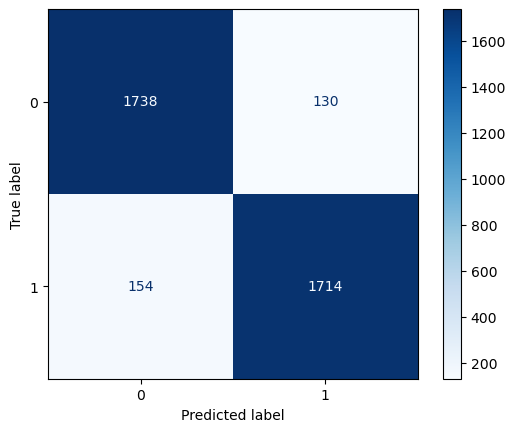

In [67]:
# View confusion matrix
ConfusionMatrixDisplay.from_estimator(gs_logr, X_test, y_test, cmap='Blues', values_format='d');

Ok for our particular data science problem, we need to minimize False Negatives (in my ds problem, the positive class is a human answer.). My reasoning is that I don't want to mislabel an actual human reddit user as a bot. I'd rather miss a bot and misclassify it as a human than misclassify a human as a bot. 

So we want to maximize Sensitivity/True Positive Rate/Recall (tp/tp+fn) 'Among those that are Human, how many did I get correct...i want to get as many of them correct)' 

In [110]:
# Sensitivity
tp/(tp+fn)

0.9063169164882227

In [111]:
# SPecificity
tn/(tn+fp)

0.9250535331905781

Lets look at the true values of y_test, and then the predicted probablilities based on my model

In [112]:
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs': gs_logr.predict_proba(X_test)[:,1]})

pred_df.head()

,true_values,pred_probs
4728,1,0.443819
3157,1,0.583421
12948,0,0.261954
4036,1,0.998259
5839,1,0.987532


C:\Users\kalya\AppData\Local\Temp\ipykernel_12356\2358283208.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')


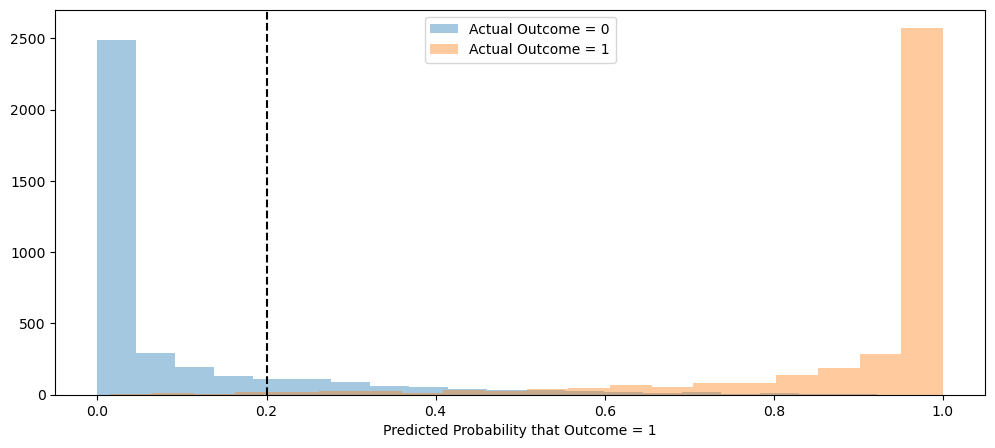

In [116]:
plt.figure(figsize = (12, 5))

# plot distributions of predicted probabilities by actual values
for group in pred_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')
    
# Add cutoff line
plt.axvline(0.2, color = 'black', linestyle = '--')

plt.xlabel('Predicted Probability that Outcome = 1')
plt.legend();

So 0.2 looks like an ok Threshold for us. Currently, I'm pretty sure the default threshold is 0.5(look at all the orange we would be missing---or humans we would be mis classifying as bots) I just don't really know how to implement that. Oh well. Let's go to another model.

In [130]:
thresholds

array([inf,  1.,  0.])

# Now for a Multinomial Naive bayes

I'm going to use a stemmer here. First time I've done it, let's see if it's worth it

In [134]:
# using PorterStemmer for the first time
stemmer = PorterStemmer()
def great_tokenizer(text):
    # This is what the default tokenizer does (None)...just splits by word
    tokens = text.split() 
    
    # Apply stemming to each token
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    
    return stemmed_tokens

In [136]:
tvec = TfidfVectorizer(max_df=0.9, max_features=2000, min_df=5, ngram_range=(1, 2), stop_words=None, tokenizer=great_tokenizer)
X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)

In [137]:
pd.DataFrame(X_train_tvec.todense(), columns=tvec.get_feature_names_out()).iloc[:, 500:550]

,don't have,don't know,don't think,done,don’t,down,draw,drink,drive,drop,...,employ,encourag,end,end of,end up,energi,engag,english,enjoy,enough
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
11202,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.026834,0.033612,0.0,0.0,0.0,0.0,0.0,0.0
11203,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
11204,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


Cool, but i got some weird warnings/errors when using in combination with stop words....previous iterations and explorations have shown that removing stop words won't increase model performance all that much, so I'll grid search with the tokenizer and with no consideration for stop words and see

In [140]:
mnb_params = {
        'tfidf__max_features': [1000,2000],
        'tfidf__min_df': [1,5,10],
        'tfidf__max_df': [0.9, 0.95],
        'tfidf__stop_words': [None],
        'tfidf__ngram_range': [(1, 2)],
        'tfidf__tokenizer':[None, great_tokenizer]
    }

In [139]:
tgif_mnb_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()), 
    ('mnb', MultinomialNB()) 
])

In [144]:
mnb_gs = GridSearchCV(tgif_mnb_pipe, param_grid=mnb_params) 

mnb_gs.fit(X_train,y_train)

C:\Users\kalya\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\kalya\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\kalya\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\kalya\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\kalya\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\kalya\anaconda3\Lib\site-packages\sk

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'tfidf__max_df': [0.9, 0.95],
                         'tfidf__max_features': [1000, 2000],
                         'tfidf__min_df': [1, 5, 10],
                         'tfidf__ngram_range': [(1, 2)],
                         'tfidf__stop_words': [None],
                         'tfidf__tokenizer': [None,
                                              <function great_tokenizer at 0x000001E014353F60>]})

In [146]:
mnb_gs.score(X_train,y_train)

0.8796180617526325

In [147]:
mnb_gs.score(X_test,y_test)

0.8685760171306209

In [148]:
mnb_gs.best_params_

{'tfidf__max_df': 0.9,
 'tfidf__max_features': 2000,
 'tfidf__min_df': 5,
 'tfidf__ngram_range': (1, 2),
 'tfidf__stop_words': None,
 'tfidf__tokenizer': <function __main__.great_tokenizer(text)>}

In [150]:
def find_cm(preds):
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
    print(f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}")
    
    print(f"Sensitivity: {tp/(tp+fn)}\nSpecificity: {tn/(tn + fp)}")
    
    return tn, fp, fn, tp

In [152]:
# Get predictions
preds = mnb_gs.predict(X_test)
# Save confusion matrix values
tn, fp, fn, tp = find_cm(preds)

TN: 1484
FP: 384
FN: 107
TP: 1761
Sensitivity: 0.9427194860813705
Specificity: 0.7944325481798715


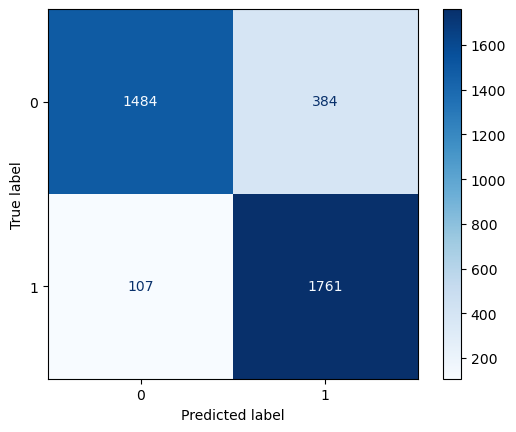

In [153]:
ConfusionMatrixDisplay.from_estimator(mnb_gs, X_test, y_test, cmap='Blues', values_format='d');

Wow, so there was an overall decrease in accuracy using the mn BUT ALSO THE STEMMING. But there is a marked improvement in sensitivity. WHich is really what im going for.

Ok lets plot the predicted proabilities by actual values

C:\Users\kalya\AppData\Local\Temp\ipykernel_12356\478947645.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')


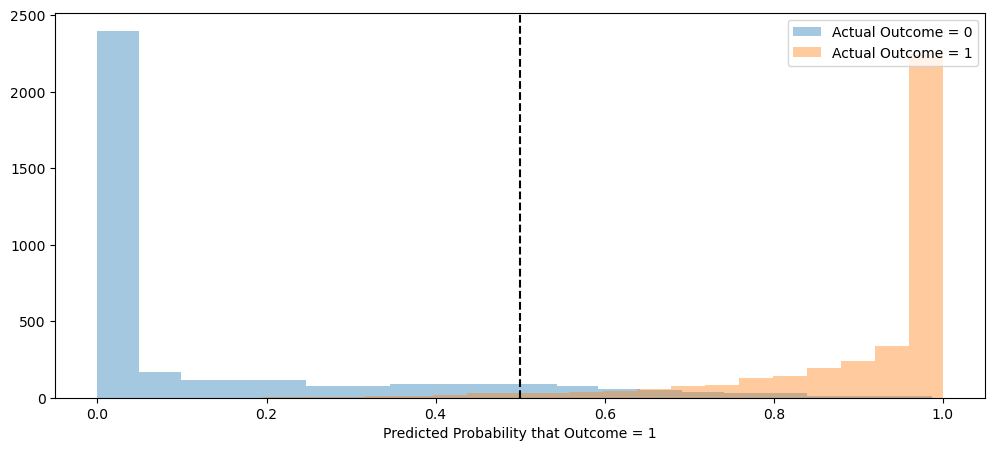

In [155]:
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs': mnb_gs.predict_proba(X_test)[:,1]})

plt.figure(figsize = (12, 5))

# plot distributions of predicted probabilities by actual values
for group in pred_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')
    
# Add cutoff line
plt.axvline(0.5, color = 'black', linestyle = '--')

plt.xlabel('Predicted Probability that Outcome = 1')
plt.legend();

# Ok now Bernoulli NB

In [156]:
tgif_bnb_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()), 
    ('bnb', BernoulliNB()) 
])

Didn't do any real hyperparameter tuning. Just wanted to see the difference in performance between mnb and bnb. I also just like using gridsearch and pipelines. 

In [158]:
bnb_params = {
        'tfidf__max_features': [2000],
        'tfidf__min_df': [5],
        'tfidf__max_df': [0.9],
        'tfidf__stop_words': [None],
        'tfidf__ngram_range': [(1, 2)],
        'tfidf__tokenizer':[great_tokenizer]
    }

bnb_gs = GridSearchCV(tgif_bnb_pipe, param_grid=bnb_params) 

bnb_gs.fit(X_train,y_train)

C:\Users\kalya\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\kalya\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\kalya\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\kalya\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\kalya\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\kalya\anaconda3\Lib\site-packages\sk

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('bnb', BernoulliNB())]),
             param_grid={'tfidf__max_df': [0.9], 'tfidf__max_features': [2000],
                         'tfidf__min_df': [5], 'tfidf__ngram_range': [(1, 2)],
                         'tfidf__stop_words': [None],
                         'tfidf__tokenizer': [<function great_tokenizer at 0x000001E014353F60>]})

In [160]:
bnb_gs.score(X_train,y_train)

0.7819917901124398

In [159]:
bnb_gs.score(X_test,y_test)

0.7917558886509636

In [161]:
# Get predictions
preds = bnb_gs.predict(X_test)
# Save confusion matrix values
tn, fp, fn, tp = find_cm(preds)

TN: 1806
FP: 62
FN: 716
TP: 1152
Sensitivity: 0.6167023554603854
Specificity: 0.9668094218415417


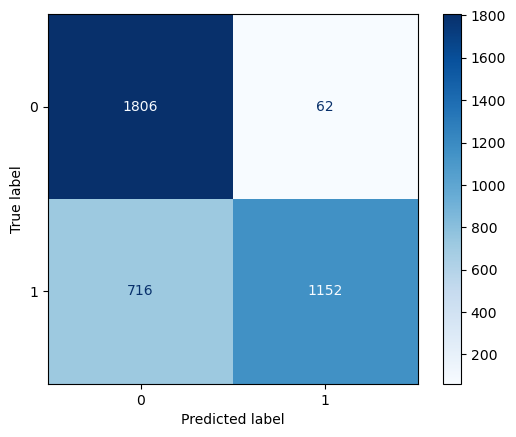

In [163]:
ConfusionMatrixDisplay.from_estimator(bnb_gs, X_test, y_test, cmap='Blues', values_format='d');

C:\Users\kalya\AppData\Local\Temp\ipykernel_12356\426274198.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')


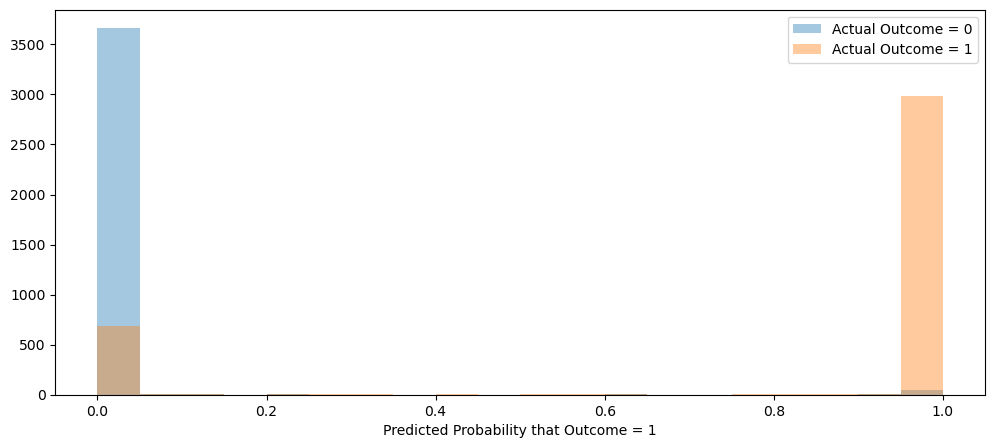

In [166]:
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs': bnb_gs.predict_proba(X_test)[:,1]})

plt.figure(figsize = (12, 5))

# plot distributions of predicted probabilities by actual values
for group in pred_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')
    

plt.xlabel('Predicted Probability that Outcome = 1')
plt.legend();

Wow this is interesting. 

# ok Logistic Regression Again, but this time with stemming

In [170]:
# AGain, no real tuning. Just curious if stemming has a big change from non stemming
tfidf_params = {
        'tfidf__max_features': [2000],
        'tfidf__min_df': [5],
        'tfidf__max_df': [0.9],
        'tfidf__stop_words': [None],
        'tfidf__ngram_range': [(1, 2)],
        'tfidf__tokenizer':[great_tokenizer],
        'logr__C': [1],
        'logr__penalty': ['l2'],
        'logr__solver': ['liblinear']
    }

tgif_logr_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()), 
    ('logr', LogisticRegression()) # this is in anticipation of the next question
])



logr_gs = GridSearchCV(
    tgif_logr_pipe,# change this based on which vectorizer i want to use
    param_grid=tfidf_params,
    cv=5  # Number of cross-validation folds
)

In [171]:
logr_gs.fit(X_train,y_train)

C:\Users\kalya\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\kalya\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\kalya\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\kalya\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\kalya\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\kalya\anaconda3\Lib\site-packages\sk

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('logr', LogisticRegression())]),
             param_grid={'logr__C': [1], 'logr__penalty': ['l2'],
                         'logr__solver': ['liblinear'], 'tfidf__max_df': [0.9],
                         'tfidf__max_features': [2000], 'tfidf__min_df': [5],
                         'tfidf__ngram_range': [(1, 2)],
                         'tfidf__stop_words': [None],
                         'tfidf__tokenizer': [<function great_tokenizer at 0x000001E014353F60>]})

In [172]:
logr_gs.score(X_train,y_train)

0.932179189719793

In [173]:
logr_gs.score(X_test,y_test)

0.9092612419700214

In [174]:
# Get predictions
preds = logr_gs.predict(X_test)
# Save confusion matrix values
tn, fp, fn, tp = find_cm(preds)

TN: 1711
FP: 157
FN: 182
TP: 1686
Sensitivity: 0.9025695931477516
Specificity: 0.9159528907922913


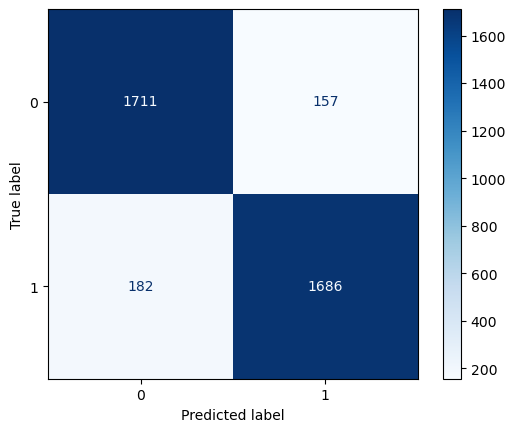

In [175]:
ConfusionMatrixDisplay.from_estimator(logr_gs, X_test, y_test, cmap='Blues', values_format='d');

C:\Users\kalya\AppData\Local\Temp\ipykernel_12356\2281383770.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')


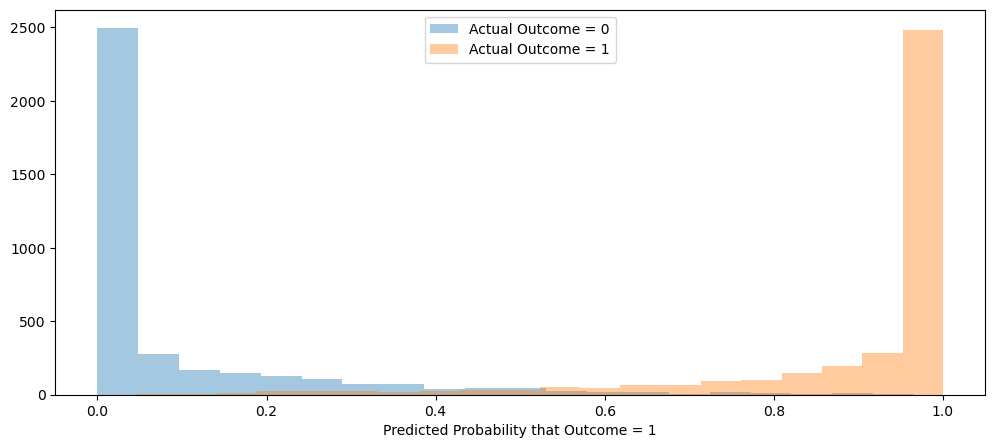

In [177]:
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs': logr_gs.predict_proba(X_test)[:,1]})

plt.figure(figsize = (12, 5))

# plot distributions of predicted probabilities by actual values
for group in pred_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')
    

plt.xlabel('Predicted Probability that Outcome = 1')
plt.legend();

Looks like it wasn't that much better at all. Oh well, it was an interesting experiment

# Conclusions

The best model here is the MNB due to the high sensitivity. I want to decrease False Negatives as much as possible so the 94.3% Sensitivity makes me happy.

In [178]:
mnb_gs.predict(['Am I finished yet? I think so'])

array([1], dtype=int64)

A human classification. I like my model

# Misc

Here I look at the common words when the sklearn stop words are removed

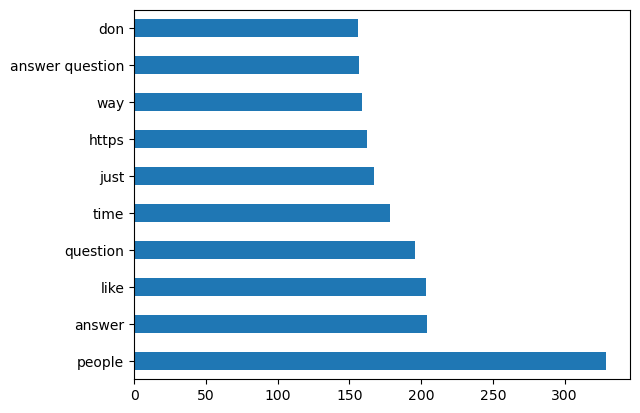

In [123]:
tvec = TfidfVectorizer(max_df=0.9, max_features=2000, min_df=5, ngram_range=(1, 2), stop_words='english')
X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)
# convert training data to dataframe
X_train_df = pd.DataFrame(X_train_tvec.todense(), columns=tvec.get_feature_names_out())

X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh');

Here, I mess around with figuring out what an roc curve is

In [179]:
from sklearn import metrics

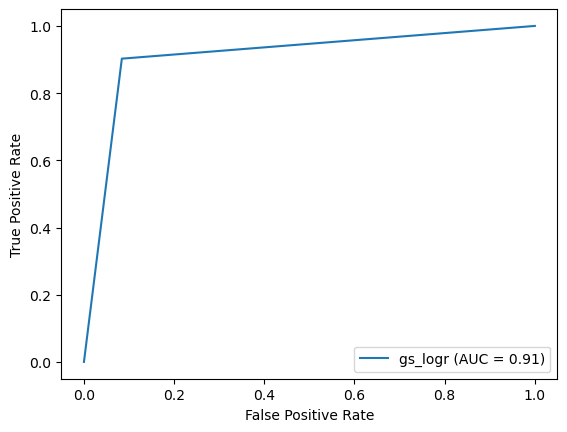

In [181]:
fpr, tpr,thresholds = metrics.roc_curve(y_test,logr_gs.predict(X_test) )
roc_auc = metrics.auc(fpr, tpr)

display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='gs_logr')

display.plot()
plt.show()

